In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import datareader

In [2]:
from activities import Activities

In [3]:
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.model_selection import train_test_split

## Constants

In [4]:
sample_frequency = 200 # Hz
chunk_size = 5 # In seconds
seed = 1

## Data reading

In [5]:
used_files = [('data/2018-06-1017.48.48 running last few seconds stair .csv', Activities.RUNNING), ('data/2018-06-1211.41.13 cycling .csv', Activities.CYCLING), ('data/2018-06-1018.05.57 fast running .csv', Activities.RUNNING), ('data/2018-06-1214.23.46 Walking .csv', Activities.WALKING), ('data/2018-06-2012.25.52 sitting.csv', Activities.SITTING), ('data/2018-06-2011.12.35 down stairs.csv', Activities.STAIRS_DOWN), ('data/2018-06-2012.53.55down stairs.csv', Activities.STAIRS_DOWN), ('data/2018-06-2016.19.41down stairs.csv', Activities.STAIRS_DOWN), ('data/2018-06-2016.20.39 walking .csv', Activities.WALKING), ('data/2018-06-2016.25.57cycling.csv', Activities.CYCLING), ('data/2018-06-2113.03.21running.csv', Activities.RUNNING), ('data/2018-06-2213.53.38sitting.csv', Activities.SITTING), ('data/2018-06-2214.56.48stairs down .csv', Activities.STAIRS_DOWN)]
dataset, labels = datareader.get_dataset(used_files, fs = sample_frequency, chunk_size = chunk_size)
dataset = np.array(dataset)
labels = np.array(labels)

data/2018-06-1017.48.48 running last few seconds stair .csv Activities.RUNNING
data/2018-06-1211.41.13 cycling .csv Activities.CYCLING
data/2018-06-1018.05.57 fast running .csv Activities.RUNNING
data/2018-06-1214.23.46 Walking .csv Activities.WALKING
data/2018-06-2012.25.52 sitting.csv Activities.SITTING
data/2018-06-2011.12.35 down stairs.csv Activities.STAIRS_DOWN
data/2018-06-2012.53.55down stairs.csv Activities.STAIRS_DOWN
data/2018-06-2016.19.41down stairs.csv Activities.STAIRS_DOWN
data/2018-06-2016.20.39 walking .csv Activities.WALKING
data/2018-06-2016.25.57cycling.csv Activities.CYCLING
data/2018-06-2113.03.21running.csv Activities.RUNNING
data/2018-06-2213.53.38sitting.csv Activities.SITTING
data/2018-06-2214.56.48stairs down .csv Activities.STAIRS_DOWN


In [6]:
print("Got", labels.shape[0], "chunks of", chunk_size, "seconds each for a total of", chunk_size*labels.shape[0], "seconds of data.")
for activity in Activities:
    print(activity,np.count_nonzero(labels == activity)*5)

Got 774 chunks of 5 seconds each for a total of 3870 seconds of data.
Activities.WALKING 595
Activities.RUNNING 1140
Activities.CYCLING 1130
Activities.SITTING 870
Activities.STAIRS_DOWN 135


## Preprocessing

In [7]:
dominating_frequency, dominating_frequency_unlabeld = datareader.generate_statistics(dataset,labels)
labels_int = np.array([x.value for x in labels])

## Classifier

In [8]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cvscores = []
for train, test in kfold.split(dominating_frequency_unlabeld, labels_int):
    clf = tree.DecisionTreeClassifier()
    clf.fit(dominating_frequency_unlabeld[train], labels_int[train])
    scores = accuracy_score(labels_int[test], clf.predict(dominating_frequency_unlabeld[test]))
    print("%.2f%%" % (scores*100))
    cvscores.append(scores * 100)
print("Accuracy: %.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

82.28%
81.01%
78.48%
83.54%
85.90%
89.74%
90.91%
84.21%
86.67%
87.84%
Accuracy: 85.06% (+/- 3.71%)


### Confusion matrix

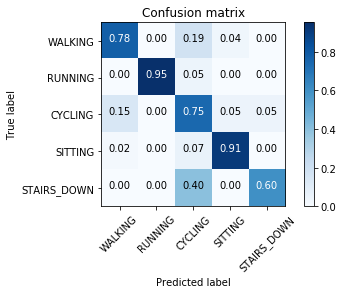

In [9]:
clf = tree.DecisionTreeClassifier()
X_train, X_test, y_train, y_test = train_test_split(dominating_frequency_unlabeld, labels_int, test_size = 0.25, random_state=seed)
y_pred = clf.fit(X_train, y_train).predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

classes = [str(activity).split(".")[1] for activity in Activities]
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

fmt= '.2f'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig("figures/conf_matrix_dt.png")

# LSTM solution

### Constants 

In [10]:
epochs = 5
lstm_units = 64

In [11]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM, Input, Activation
from sklearn.utils import class_weight
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse=False)

/usr/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### The model

In [12]:
def get_model():
    model = Sequential()
    model.add(LSTM(lstm_units, input_shape=(3, 1000)))
    model.add(Dropout(0.2))
    model.add(Dense(len(Activities), activation='sigmoid'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop', metrics=['accuracy'])
    return model
model = get_model()

### Prepairing data for the model

In [13]:
# Try to keep categories equally important
sum = 0
class_weights = {}
for i,activity in enumerate(Activities):
    class_weights[i] = 1/np.count_nonzero(labels == activity)
    sum+=class_weights[i]
for i,activity in enumerate(Activities):
    class_weights[i]/=sum
print(class_weights)

{0: 0.1400600643283637, 1: 0.07310152480296177, 2: 0.07374844095166054, 3: 0.09578820491422577, 4: 0.6173017650027882}


### Confusion matrix

Train on 580 samples, validate on 194 samples
Epoch 1/5
580/580 [==============================] - 2s 3ms/step - loss: 0.1508 - acc: 0.7517 - val_loss: 1.1625 - val_acc: 0.8711
Epoch 2/5
580/580 [==============================] - 0s 647us/step - loss: 0.1176 - acc: 0.9241 - val_loss: 1.0260 - val_acc: 0.8814
Epoch 3/5
580/580 [==============================] - 0s 712us/step - loss: 0.0990 - acc: 0.9397 - val_loss: 0.9225 - val_acc: 0.9021
Epoch 4/5
580/580 [==============================] - 0s 685us/step - loss: 0.0838 - acc: 0.9569 - val_loss: 0.8289 - val_acc: 0.9175
Epoch 5/5
580/580 [==============================] - 0s 694us/step - loss: 0.0677 - acc: 0.9569 - val_loss: 0.7489 - val_acc: 0.9227


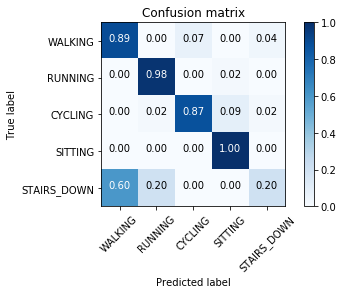

In [18]:
# Training on test data
y_categorical = enc.fit_transform(labels_int.reshape((labels_int.shape[0]),1))
X_train, X_test, y_train, y_test = train_test_split(dataset, y_categorical, test_size = 0.25, random_state=seed)

model = get_model()
model.fit(X_train, y_train, epochs = epochs,class_weight=class_weights, validation_data=(X_test, y_test))

# Generating confusion matrix
y_pred = model.predict(X_test)
y_test_non_category = [ np.argmax(t) for t in y_test]
y_predict_non_category = [ np.argmax(t) for t in y_pred]

cm = confusion_matrix(y_test_non_category, y_predict_non_category)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plotting
classes = [str(activity).split(".")[1] for activity in Activities]
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

fmt= '.2f'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig("figures/conf_matrix_lstm.png")

In [15]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cvscores = []
for train, test in kfold.split(dataset, labels_int):
    y_categorical = enc.fit_transform(labels_int[train].reshape((labels_int[train].shape[0]),1))
    y_categorical_test = enc.fit_transform(labels_int[test].reshape((labels_int[test].shape[0]),1))
    model = get_model()
    model.fit(dataset[train], y_categorical, epochs = epochs,class_weight=class_weights, validation_data=(dataset[test], y_categorical_test))

    scores = model.evaluate(dataset[test], y_categorical_test, verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

Train on 695 samples, validate on 79 samples
Epoch 1/5
695/695 [==============================] - 1s 2ms/step - loss: 0.1436 - acc: 0.7813 - val_loss: 1.1445 - val_acc: 0.8228
Epoch 2/5
695/695 [==============================] - 0s 533us/step - loss: 0.1091 - acc: 0.9237 - val_loss: 1.0074 - val_acc: 0.8734
Epoch 3/5
695/695 [==============================] - 0s 543us/step - loss: 0.0895 - acc: 0.9309 - val_loss: 0.9130 - val_acc: 0.8861
Epoch 4/5
695/695 [==============================] - 0s 574us/step - loss: 0.0726 - acc: 0.9482 - val_loss: 0.8209 - val_acc: 0.8861
Epoch 5/5
695/695 [==============================] - 0s 527us/step - loss: 0.0592 - acc: 0.9597 - val_loss: 0.7326 - val_acc: 0.8734
acc: 87.34%
Train on 695 samples, validate on 79 samples
Epoch 1/5
695/695 [==============================] - 1s 2ms/step - loss: 0.1462 - acc: 0.7237 - val_loss: 1.1541 - val_acc: 0.8481
Epoch 2/5
695/695 [==============================] - 0s 605us/step - loss: 0.1099 - acc: 0.9396 - val_lo